<a href="https://colab.research.google.com/github/stephenbeckr/numerical-analysis-class/blob/master/Demos/Ch5_OrbitDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Orbit demo
We'll discuss integration for equations of motions for planets

You can do this for N-bodies (since for $\ge 3$ bodies, there is [no analytic solution](https://en.wikipedia.org/wiki/Three-body_problem)), and see this [N-body_simulations scholarpedia](http://www.scholarpedia.org/article/N-body_simulations) for details. You can get data from [ssd.jpl.nasa.gov/horizons.cgi](http://ssd.jpl.nasa.gov/horizons.cgi).

However, for our purposes, let's just keep it simple, and do a 1-body problem: the Earth revolving around the sun, and we assume the sun is so big that it's position is static (at $(0,0)$).  We're also doing this because I'm borrowing and adapting python code from [stackoverflow.com/q/60868979](https://stackoverflow.com/q/60868979).

As this is classical mechanics, we have a 2nd order ODE, and we have 2 dimensions (it's 3 dimensional, but planets orbit in a plane, so we can assume the $(x,y)$ coordinates are parallel to this plane).  We use [Newton's law of universal gravitation](https://en.wikipedia.org/wiki/Newton%27s_law_of_universal_gravitation#Vector_form) to compute the acceleration (since it gives us $F$ and $F=ma$)
$$
\mathbf{a} =\mathbf{v}'= \frac{1}{m_\textrm{Earth}}\mathbf{F}
$$
and 
$$
\mathbf{F} = -G\frac{m_{\textrm{Earth}} M_{\textrm{Sun}} }{\|\mathbf{r}\|^2} \mathbf{\hat r}
$$
where
$$
\mathbf{\hat r}=\frac{\mathbf{r}}{\|\mathbf{r}\|},\; \mathbf{r} = \mathbf{x}_\text{Earth} - \mathbf{x}_\text{sun}, \quad \mathbf{x}= (x,y), \quad \|\mathbf{x}\| = \sqrt{x^2+y^2}
$$
and we'll take $\mathbf{x}_\text{sun}=0$ for simplicity.
Thus, simplifying,
$$
\mathbf{v}' = -\mu \frac{\mathbf{x}}{\|\mathbf{x}\|^3}, \quad 
\mathbf{x}' = \mathbf{v}
$$
where
$$\mu = GM_{\textrm{Sun}}$$
is the [Standard gravitational parameter](https://en.wikipedia.org/wiki/Standard_gravitational_parameter#Small_body_orbiting_a_central_body) and we can simplify that to write $\mu=4\pi^2$ if we are in time units of 1 orbit (so 1 year) and distance units of 1 radius (so 1 [A.U.](https://en.wikipedia.org/wiki/Astronomical_unit)).

So, our ODE is given.  We have a 2nd order ODE with 2 variables, and we can rewrite this to a 1st order ODE system with 4 variables, and thus apply a method like Euler's method

## Conservation of energy
For classical mechanics simulations, if we're not interacting with anything external to the system, and not losing energy to heat and such, then we expect conservation of energy.  Our numerical methods do not necessarily respect this. 

We'll try simulating this with **forward Euler**, our simplest ODE numerical method.  Then we'll try [symplectic Euler](https://en.wikipedia.org/wiki/Semi-implicit_Euler_method) (which goes by many names, like semi-implicit Euler method, semi-explicit Euler method, Newton–Størmer–Verlet). This symplectic Euler is not higher-order but is better at conserving energy.

<p style='text-align: right;'> Demo by Stephen Becker </p>

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from numpy.linalg import norm

In [123]:
#Set parameters:
T   = 20            # Length of simulation in years
days = 1./365
h   = .25*days      # timestep
N   = int(np.ceil( T/h )) # number of time grid points
mu = 4 * np.pi**2  # mu=4pi^2 is the Gravitational Parameter: mu = GM where G=6.67e-11 is the Universal Gravitational Constant and M is the mass of the body
dist2sun = 1       # distance of Earth to sun, in A.U.
x0  = [dist2sun,0]


#Create an array, for all variables, of size N with all entries equal to zero:
x    = np.zeros((N,2))
x[0] = x0
v   = np.array( [0,1.01*np.sqrt(mu/dist2sun)] ) # in AU/year
# v   = np.array( [-mu / (dist2sun**2)*(-0.5*h), 1*np.sqrt(mu/dist2sun)] ) # for perfect circle

# Run Euler's method
for t in range(N-1):
  dist2sun = norm( x[t] )
  x[t+1] = x[t] + h*v
  v     -= h*(mu*x[t]/(dist2sun**3))
xEuler = x.copy()

# Run symplectic Euler's method
# Code based off https://stackoverflow.com/a/60988059
# Reset the initial conditions:
x = 0*x
x[0] = x0
dist2sun = 1
v   = np.array( [0,1.01*np.sqrt(mu/dist2sun)] )
for t in range(N-1):
  dist2sun = norm( x[t] )
  v -= h*(mu*x[t]/(dist2sun**3)) # this is the big change!!
  x[t+1] = x[t] + h*v
  # v -= h*(mu*x[t]/(dist2sun**3))

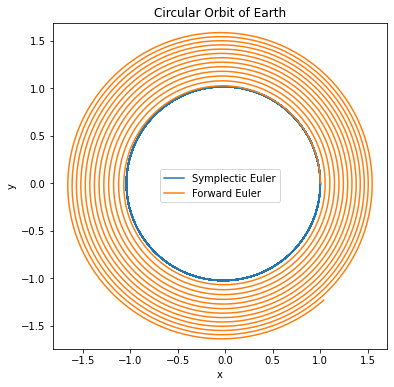

In [126]:
fig = plt.figure(figsize=(6,6))
fig.gca().set(xlim=(-1.1, 1.1), ylim=(-1.1, 1.1))
plt.plot(x[:,0], x[:,1], '-',label='Symplectic Euler')
plt.plot(xEuler[:,0], xEuler[:,1], '-',label='Forward Euler')
plt.title('Circular Orbit of Earth')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.legend()
plt.show()

In [134]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(6,6))
# ax = plt.axes(xlim=(-1.1, 1.1), ylim=(-1.1, 1.1))
# fig,ax = plt.subplots()
ax = fig.gca()
line, = ax.plot([], [], 'o')
trace, = ax.plot([], [], '-',lw=1,label='Forward Euler')
lineSymplectic, = ax.plot([], [], 'o')
traceSymplectic, = ax.plot([], [], '-',lw=1,label='Symplectic Euler')
ax.axis('equal')
ax.set(xlim=(-2.1, 2.1), ylim=(-2.1, 2.1))
plt.title('Circular Orbit of Earth')
plt.xlabel('x')
plt.ylabel('y')
plt.close()

N_reasonable = 200 # keep this not too large, otherwise animate function is unhappy
skip = int( N/N_reasonable )

# initialization function: plot the background of each frame
def init():
  line.set_data([], [])
  trace.set_data([], [])
  lineSymplectic.set_data([], [])
  traceSymplectic.set_data([], [])
  return line,trace,lineSymplectic,traceSymplectic,

# animation function.  This is called sequentially
def animate(j):
  #i = j*skip  # show entire time period, but jumpy
  i = 50*j  # smoother, but not all time
  xx,yy = xEuler[i]
  line.set_data(xx, yy)
  trace.set_data(xEuler[:i,0],xEuler[:i,1])
  xx,yy = x[i]
  lineSymplectic.set_data(xx, yy)
  traceSymplectic.set_data(x[:i,0],x[:i,1])
  return line,trace,lineSymplectic,traceSymplectic,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=N_reasonable, interval=200, blit=True)
# To get to work in Colab, see 
# https://colab.research.google.com/drive/1lnl5UPFWVPrryaZZgEzd0theI6S94c3X
rc('animation', html='jshtml')
anim